In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import argparse
import os
import sys

import mlflow
import numpy as np
import scanpy as sc
import squidpy as sq

from autotalker.data import download_nichenet_ligand_target_mx
from autotalker.data import load_spatial_adata_from_csv
from autotalker.models import Autotalker

In [13]:
dataset = "squidpy_seqfish"
n_epochs = 5
lr = 0.01
batch_size = 32
n_hidden = 32
n_latent = 16
dropout_rate = 0.

In [14]:
print(f"Using dataset {dataset}.")

if dataset == "deeplinc_seqfish":
    adata = load_spatial_adata_from_csv("datasets/seqFISH/counts.csv",
                                        "datasets/seqFISH/adj.csv")
    cell_type_key = None
elif dataset == "squidpy_seqfish":
    adata = sq.datasets.seqfish()
    sq.gr.spatial_neighbors(adata, radius = 0.04, coord_type="generic")
    cell_type_key = "celltype_mapped_refined"
elif dataset == "squidpy_slideseqv2":
    adata = sq.datasets.slideseqv2()
    sq.gr.spatial_neighbors(adata, radius = 30.0, coord_type="generic")
    cell_type_key = "celltype_mapped_refined"

Using dataset squidpy_seqfish.


/Users/sebastian.birk/opt/anaconda3/envs/autotalkercpu/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [15]:
print(f"Number of nodes: {adata.X.shape[0]}")
print(f"Number of node features: {adata.X.shape[1]}")
avg_edges_per_node = round(
    adata.obsp['spatial_connectivities'].toarray().sum(axis=0).mean(),2)
print(f"Average number of edges per node: {avg_edges_per_node}")
n_edges = int(np.triu(adata.obsp['spatial_connectivities'].toarray()).sum())
print(f"Number of edges: {n_edges}", sep="")

Number of nodes: 19416
Number of node features: 351
Average number of edges per node: 4.4
Number of edges: 42694


In [16]:
os.makedirs("mlruns", exist_ok=True)

In [17]:
experiment = mlflow.set_experiment("autotalker")
mlflow.log_param("dataset", dataset)

In [18]:
# Mask that allows all genes
mask = np.ones((n_latent, len(adata.var)))

In [19]:
model = Autotalker(adata,
                   mask=mask,
                   n_hidden=n_hidden,
                   n_latent=n_latent,
                   dropout_rate=dropout_rate,
                   expr_decoder_recon_loss="nb")

GCN ENCODER - n_input: 351, n_hidden: 32, n_latent: 16, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER - dropout_rate: 0.0


In [20]:
model.train(n_epochs=n_epochs,
            lr=lr,
            batch_size=batch_size,
            mlflow_experiment_id=experiment.experiment_id)

 |████----------------| 20.0%  - train_loss: 1.9967428929 - valid_loss: 0.2929388887 - valid_auroc_score: 0.6839361894 - valid_auprc_score: 0.6801504303 - valid_best_acc_score: 0.6820464983 - valid_best_f1_score: 0.7482190057Epoch end
 |████████------------| 40.0%  - train_loss: 0.2982443301 - valid_loss: 0.2837734460 - valid_auroc_score: 0.6540828558 - valid_auprc_score: 0.6748755950 - valid_best_acc_score: 0.6548776550 - valid_best_f1_score: 0.7211890149Epoch end
 |████████████--------| 60.0%  - train_loss: 0.2889073182 - valid_loss: 0.3129848595 - valid_auroc_score: 0.5551662511 - valid_auprc_score: 0.6379617352 - valid_best_acc_score: 0.6210623565 - valid_best_f1_score: 0.6789660333Epoch end
 |████████████████----| 80.0%  - train_loss: 0.2979997090 - valid_loss: 0.3092195392 - valid_auroc_score: 0.6729774384 - valid_auprc_score: 0.6521964165 - valid_best_acc_score: 0.6748349598 - valid_best_f1_score: 0.7460407199Epoch end
 |████████████████████| 100.0%  - train_loss: 0.2901925003 -

In [21]:
model.save(dir_path="./model_artefacts",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

In [22]:
model = Autotalker.load(dir_path="./model_artefacts",
                        adata=None,
                        adata_file_name="adata.h5ad",
                        use_cuda=True)

GCN ENCODER - n_input: 351, n_hidden: 32, n_latent: 16, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER - dropout_rate: 0.0


In [23]:
latent = model.get_latent_representation()

In [24]:
latent_new_data = model.get_latent_representation(adata)

In [25]:
adata.obsm["latent_autotalker"] = latent_new_data

## Interoperability with scanpy

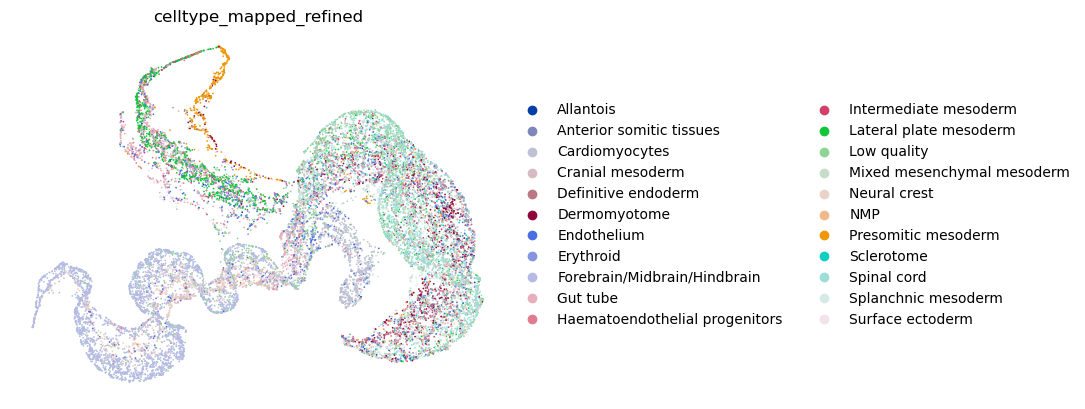

In [26]:
# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=["celltype_mapped_refined"], frameon=False,)

In [ ]:
download_nichenet_ligand_target_mx(save_path="data/ligand_target_matrix.csv")

In [ ]:
adata.var

In [ ]:
model = Autotalker(adata=adata,
                   mask=mask,
                   n_hidden=n_hidden)

In [ ]:
experiment = mlflow.set_experiment("autotalker")
mlflow.log_param("dataset", dataset)

In [ ]:
model.train(n_epochs=n_epochs,
            lr=lr,
            batch_size=batch_size,
            mlflow_experiment_id=experiment.experiment_id)